# Clustering stocks with K-Means

Clustering is a powerful technique with many use cases. In the financial industry, it can be used to group equities with similar risk and return characteristics. This can be of great value for investors looking to gain insights to further inform their portfolio allocation and investment decisions. In this project, I randomly sample 100 stocks from the S&P 500 Index. Theses equities are then clustered using the K-Means algorithm.  


#### Project Outline:
- Data Collection
- EDA & Data Cleaning
- Feature Engineering
- K-Means Clustering


In [1]:
# Importing packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
pd.set_option("max.columns", 100)
pd.set_option("max.rows", None)

## Download Data

In [2]:
# Define function to get S&P 500 tickers
def get_tickers():
    sp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    data_table = pd.read_html(sp500url)
    stock_tickers = list(data_table[0]["Symbol"])
    
    # Replace "BRK.B" with "BRK-B" and "BF.B" with "BF-B"
    for i in range(len(stock_tickers)):
        if stock_tickers[i] == "BRK.B":
            stock_tickers[i] = "BRK-B"
        elif stock_tickers[i] == "BF.B":
            stock_tickers[i] = "BF-B"
    
    # Exclude "KVUE" and "VLTO" as they return an error message
    excluded_tickers = ["KVUE", "VLTO"]
    stock_tickers = [ticker for ticker in stock_tickers if ticker not in excluded_tickers]
    
    return stock_tickers

In [3]:
# Call function and store tickers
sp500_tickers = get_tickers()

# Randomly sample 100 tickers/stocks for the analysis
my_tickers = random.sample(sp500_tickers, 100)

# Download price data from yahoo
df = yf.download(tickers=my_tickers, start="2020-01-01", end="2022-12-31")["Adj Close"]

[*********************100%***********************]  100 of 100 completed


## Exploratory Data Analysis 

In [4]:
df.head()

,A,ADP,AIG,AMP,ANSS,AON,AOS,AVB,AVGO,AVY,BALL,BKNG,BMY,BSX,CAG,CAH,CCI,CE,CHRW,CI,CME,CMG,COO,COR,CTVA,DD,DTE,DVN,ECL,EL,ELV,ENPH,EOG,EQT,ESS,EVRG,EW,EXR,GEN,GOOGL,GPC,HAS,HCA,HIG,HWM,IBM,ILMN,IQV,JBHT,JKHY,KEY,KMB,LEN,LH,LLY,LVS,LYV,MAR,MAS,MHK,MKC,MRK,MSCI,MTD,NCLH,NEE,NFLX,NUE,NVDA,O,PCG,PH,PODD,PWR,QCOM,QRVO,RMD,ROK,SEE,SNA,SPGI,TDG,TECH,TFC,TRGP,TSCO,TSLA,TSN,TTWO,TXT,V,VICI,VRSN,VTR,VTRS,WAB,WMT,WRK,XEL,ZBH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.779152,157.518631,46.450272,157.328384,259.589996,202.597183,44.557995,181.562393,284.935608,121.607101,61.460239,2074.580078,56.170094,45.330002,29.678444,44.262268,123.248123,110.907211,71.006767,195.361221,177.715424,858.190002,323.102173,80.618301,27.366377,59.034554,96.660446,20.289568,182.553757,199.369980,287.446350,29.340000,69.168610,10.005585,261.785248,55.264175,77.500000,92.017006,13.814827,68.433998,95.409363,92.360252,142.945541,55.566322,31.304722,107.512413,327.000000,156.410004,113.820496,139.767166,16.963902,119.665565,52.975498,140.942780,124.954697,69.175591,71.889999,148.770981,45.337151,134.789993,78.628151,77.975151,257.524323,805.059998,58.830002,55.027332,329.809998,50.743179,59.749294,59.200893,10.85,197.418335,169.770004,40.652084,81.464783,115.959999,151.520020,192.600235,36.618126,153.226471,268.935272,551.744446,54.071587,48.273300,36.986065,88.068329,28.684000,81.496048,122.080002,45.235523,186.293213,20.808495,196.729996,48.018669,18.705511,79.015572,112.085136,39.337616,56.082611,140.791580
2020-01-03,82.433998,157.185654,46.091316,155.366791,256.970001,201.801514,44.166237,183.305847,277.688232,120.854759,62.316521,2065.479980,55.673473,44.980000,29.422516,43.617203,123.926674,109.400200,70.924660,193.683472,180.092590,865.130005,322.082886,79.604416,27.042627,57.788788,96.893280,20.533451,181.680481,197.862076,283.634369,29.290001,69.867355,9.986267,264.347961,55.316452,77.209999,93.589699,13.713948,68.075996,94.056793,92.114731,143.381668,55.283710,31.255096,106.654976,322.730011,154.190002,113.345924,139.604340,16.670843,119.630318,53.601971,140.732361,124.538849,68.120369,71.639999,146.590836,44.989639,130.949997,79.881287,77.305862,252.394119,789.539978,57.599998,55.419376,325.899994,50.071144,58.792950,60.270885,10.57,194.642075,171.479996,40.424541,79.930832,112.339996,150.724121,189.790466,36.043468,151.494736,268.035065,561.856812,53.386639,47.872944,37.568954,86.980576,29.534000,82.048584,122.209999,44.499493,184.811676,20.824955,200.880005,48.597713,18.297884,78.410385,111.095657,38.640499,56.352318,140.423553
2020-01-06,82.677681,157.398361,46.127209,155.878098,254.589996,202.383759,44.446064,183.612457,277.272858,119.331261,61.739254,2047.400024,55.850834,45.349998,29.581364,43.979500,122.882744,108.194557,69.802490,197.248672,180.832108,858.020020,322.952301,80.769920,27.004538,57.379730,96.870735,20.777334,180.135452,200.433258,287.045013,29.660000,72.703484,10.102162,263.294861,55.159641,78.266670,93.528198,14.011271,69.890503,92.064049,92.386574,143.924408,55.137840,30.977182,106.464447,325.529999,155.000000,111.379837,140.571915,16.419651,119.894600,55.101723,142.575409,125.001938,68.481880,71.739998,144.695465,44.642120,131.000000,80.360008,77.636276,253.652481,793.729980,56.799999,55.696098,335.829987,49.647675,59.039505,60.573109,10.38,194.726776,177.809998,40.434429,79.462379,111.639999,151.442352,191.298355,35.760841,150.379532,270.096771,568.624268,53.504902,47.472580,38.124523,86.687355,30.102667,81.659096,124.690002,44.539276,184.412003,20.610947,202.740005,49.100132,18.904795,78.088272,110.869499,38.052013,56.271416,139.612045
2020-01-07,82.931114,155.493210,45.866959,154.000168,256.670013,200.666229,44.147591,179.617462,276.318298,119.067947,61.498726,2068.050049,56.693298,45.400002,28.522364,43.997173,120.803688,107.774437,71.453812,198.211472,180.479980,860.080017,323.831665,80.191910,27.109282,56.496536,96.547813,20.840275,179.905121,199

In [5]:
# Check shape
df.shape

(756, 100)

In [5]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       756 non-null    float64
 1   ADP     756 non-null    float64
 2   AIG     756 non-null    float64
 3   AMP     756 non-null    float64
 4   ANSS    756 non-null    float64
 5   AON     756 non-null    float64
 6   AOS     756 non-null    float64
 7   AVB     756 non-null    float64
 8   AVGO    756 non-null    float64
 9   AVY     756 non-null    float64
 10  BALL    756 non-null    float64
 11  BKNG    756 non-null    float64
 12  BMY     756 non-null    float64
 13  BSX     756 non-null    float64
 14  CAG     756 non-null    float64
 15  CAH     756 non-null    float64
 16  CCI     756 non-null    float64
 17  CE      756 non-null    float64
 18  CHRW    756 non-null    float64
 19  CI      756 non-null    float64
 20  CME     756 non-null    float64
 21  CMG     756 non-nul

In [7]:
# Function that only returns columns with missing values
def percent_missing(df):
    percent_nan = 100 * df.isna().mean()
    percent_nan = percent_nan[percent_nan > 0].sort_values(ascending=False)
    
    return percent_nan

In [8]:
# Identify columns with missing values
percent_missing(df)

Series([], dtype: float64)

In [9]:
# Drop date as index
df_clean = df.reset_index().drop("Date", axis=1)
df_clean.head()

,A,ADP,AIG,AMP,ANSS,AON,AOS,AVB,AVGO,AVY,BALL,BKNG,BMY,BSX,CAG,CAH,CCI,CE,CHRW,CI,CME,CMG,COO,COR,CTVA,DD,DTE,DVN,ECL,EL,ELV,ENPH,EOG,EQT,ESS,EVRG,EW,EXR,GEN,GOOGL,GPC,HAS,HCA,HIG,HWM,IBM,ILMN,IQV,JBHT,JKHY,KEY,KMB,LEN,LH,LLY,LVS,LYV,MAR,MAS,MHK,MKC,MRK,MSCI,MTD,NCLH,NEE,NFLX,NUE,NVDA,O,PCG,PH,PODD,PWR,QCOM,QRVO,RMD,ROK,SEE,SNA,SPGI,TDG,TECH,TFC,TRGP,TSCO,TSLA,TSN,TTWO,TXT,V,VICI,VRSN,VTR,VTRS,WAB,WMT,WRK,XEL,ZBH
0,83.779152,157.518631,46.450272,157.328384,259.589996,202.597183,44.557995,181.562393,284.935608,121.607101,61.460239,2074.580078,56.170094,45.330002,29.678444,44.262268,123.248123,110.907211,71.006767,195.361221,177.715424,858.190002,323.102173,80.618301,27.366377,59.034554,96.660446,20.289568,182.553757,199.369980,287.446350,29.340000,69.168610,10.005585,261.785248,55.264175,77.500000,92.017006,13.814827,68.433998,95.409363,92.360252,142.945541,55.566322,31.304722,107.512413,327.000000,156.410004,113.820496,139.767166,16.963902,119.665565,52.975498,140.942780,124.954697,69.175591,71.889999,148.770981,45.337151,134.789993,78.628151,77.975151,257.524323,805.059998,58.830002,55.027332,329.809998,50.743179,59.749294,59.200893,10.85,197.418335,169.770004,40.652084,81.464783,115.959999,151.520020,192.600235,36.618126,153.226471,268.935272,551.744446,54.071587,48.273300,36.986065,88.068329,28.684000,81.496048,122.080002,45.235523,186.293213,20.808495,196.729996,48.018669,18.705511,79.015572,112.085136,39.337616,56.082611,140.791580
1,82.433998,157.185654,46.091316,155.366791,256.970001,201.801514,44.166237,183.305847,277.688232,120.854759,62.316521,2065.479980,55.673473,44.980000,29.422516,43.617203,123.926674,109.400200,70.924660,193.683472,180.092590,865.130005,322.082886,79.604416,27.042627,57.788788,96.893280,20.533451,181.680481,197.862076,283.634369,29.290001,69.867355,9.986267,264.347961,55.316452,77.209999,93.589699,13.713948,68.075996,94.056793,92.114731,143.381668,55.283710,31.255096,106.654976,322.730011,154.190002,113.345924,139.604340,16.670843,119.630318,53.601971,140.732361,124.538849,68.120369,71.639999,146.590836,44.989639,130.949997,79.881287,77.305862,252.394119,789.539978,57.599998,55.419376,325.899994,50.071144,58.792950,60.270885,10.57,194.642075,171.479996,40.424541,79.930832,112.339996,150.724121,189.790466,36.043468,151.494736,268.035065,561.856812,53.386639,47.872944,37.568954,86.980576,29.534000,82.048584,122.209999,44.499493,184.811676,20.824955,200.880005,48.597713,18.297884,78.410385,111.095657,38.640499,56.352318,140.423553
2,82.677681,157.398361,46.127209,155.878098,254.589996,202.383759,44.446064,183.612457,277.272858,119.331261,61.739254,2047.400024,55.850834,45.349998,29.581364,43.979500,122.882744,108.194557,69.802490,197.248672,180.832108,858.020020,322.952301,80.769920,27.004538,57.379730,96.870735,20.777334,180.135452,200.433258,287.045013,29.660000,72.703484,10.102162,263.294861,55.159641,78.266670,93.528198,14.011271,69.890503,92.064049,92.386574,143.924408,55.137840,30.977182,106.464447,325.529999,155.000000,111.379837,140.571915,16.419651,119.894600,55.101723,142.575409,125.001938,68.481880,71.739998,144.695465,44.642120,131.000000,80.360008,77.636276,253.652481,793.729980,56.799999,55.696098,335.829987,49.647675,59.039505,60.573109,10.38,194.726776,177.809998,40.434429,79.462379,111.639999,151.442352,191.298355,35.760841,150.379532,270.096771,568.624268,53.504902,47.472580,38.124523,86.687355,30.102667,81.659096,124.690002,44.539276,184.412003,20.610947,202.740005,49.100132,18.904795,78.088272,110.869499,38.052013,56.271416,139.612045
3,82.931114,155.493210,45.866959,154.000168,256.670013,200.666229,44.147591,179.617462,276.318298,119.067947,61.498726,2068.050049,56.693298,45.400002,28.522364,43.997173,120.803688,107.774437,71.453812,198.211472,180.479980,860.080017,323.831665,80.191910,27.109282,56.496536,96.547813,20.840275,179.905121,199.167007,286.175720,29.990000,73.402245,9.937978,260.073792,55.194492,77.669998,93.106476,14.202406,69.755501,91.712372,90.659126,143.730545,5

In [44]:
# Let's look at some statistics
df_clean.describe().T[:10]

,count,mean,std,min,25%,50%,75%,max
A,756.0,121.502005,26.327649,61.769444,99.097782,125.016212,141.099361,176.669464
ADP,756.0,185.430998,37.965098,101.496231,156.580631,190.476433,215.879417,264.221466
AIG,756.0,44.672511,11.857253,17.066229,35.474669,47.538101,54.506217,62.425213
AMP,756.0,223.307435,64.061966,77.471886,159.408539,240.367607,273.071526,328.571503
ANSS,756.0,308.310026,52.182870,200.330002,260.434990,315.000000,351.332497,411.220001
AON,756.0,244.586057,44.835908,141.448410,202.330112,248.237633,284.734886,329.909332
AOS,756.0,57.218799,11.277149,32.589966,49.063420,57.233473,65.426937,83.137123
AVB,756.0,180.245527,32.956010,106.077850,150.230339,181.062088,207.932205,242.861267
AVGO,756.0,424.875759,109.758745,148.367294,332.059586,444.154907,512.356705,641.669739
AVY,756.0,162.695984,36.886314,74.418594,127.987848,168.727585,195.466171,220.065704


## Feature Engineering

In [11]:
# Annualized returns and standard deviation
def returns_and_vol(df):
    daily_returns = df.pct_change(1).dropna()
    annual_mean_returns = daily_returns.mean() * 252
    annual_volatility = daily_returns.std() * np.sqrt(252)
    
    # Create new df with features
    df_features = pd.DataFrame({
        "Ticker":df.columns,
        "annual_ret":annual_mean_returns.values,
        "annual_std":annual_volatility.values
    })
    return df_features

In [12]:
df_final = returns_and_vol(df_clean)
df_final.head()

,Ticker,annual_ret,annual_std
0,A,0.241962,0.316913
1,ADP,0.186381,0.324233
2,AIG,0.214566,0.482835
3,AMP,0.335478,0.472254
4,ANSS,0.056764,0.402604


- Outliers can severely impact the clustering process when using the K-Means algorithm. We need to remove extreme outliers from our dataset before any clustering. Else they will skew our results and distort the clusters. Let's plot our data and see what it looks like.

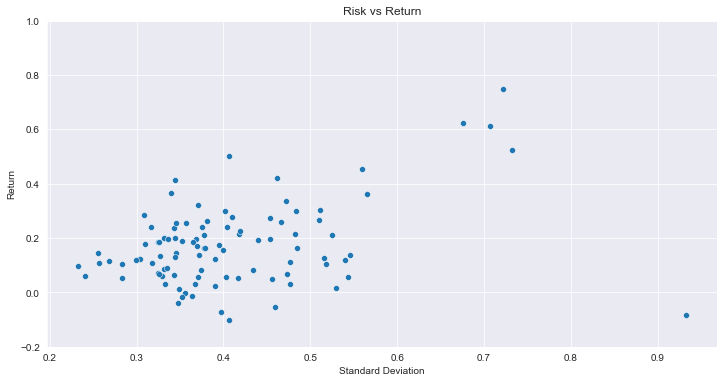

In [13]:
# Plot risk vs return
plt.figure(figsize=(12,6))
sns.scatterplot(x="annual_std", y="annual_ret", data=df_final)

plt.title("Risk vs Return")
plt.xlabel("Standard Deviation")
plt.ylabel("Return")
plt.ylim(-0.2,1)
plt.show()

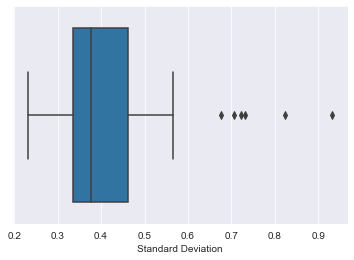

In [14]:
# Boxplot
sns.boxplot(x="annual_std", data=df_final)
plt.xlabel("Standard Deviation")
plt.show()

- We clearly have some outliers in our data. By the looks of the scatterplot and boxplot, removing observations with a standard deviation greater than 0.9 seems like a reasonable first approach. We can always tweak this threshold if needed.

In [15]:
df_final2 = df_final[df_final["annual_std"] < 0.9]

- Let's plot our data again and check if the extreme outlier in the bottom right corner has been removed.

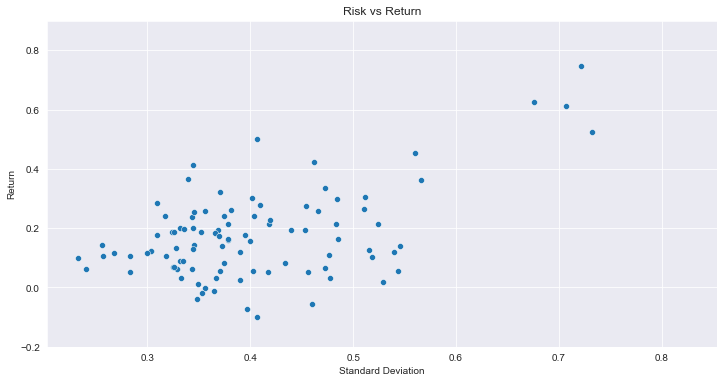

In [17]:
# Plot risk vs return without the extreme outlier
plt.figure(figsize=(12,6))
sns.scatterplot(x="annual_std", y="annual_ret", data=df_final2)

plt.title("Risk vs Return")
plt.xlabel("Standard Deviation")
plt.ylabel("Return")
plt.ylim(-0.2, 0.9)
plt.show()

## Feature Scaling

- Scaling the features is very important before fitting distance-based models. We will use RobustScaler, a great alternative when outliers are present in the data.

In [18]:
#subset data
X = df_final2[["annual_ret", "annual_std"]]
# Scale data
scaler = RobustScaler()
scaled_data = scaler.fit_transform(X)

## K-Means Clustering

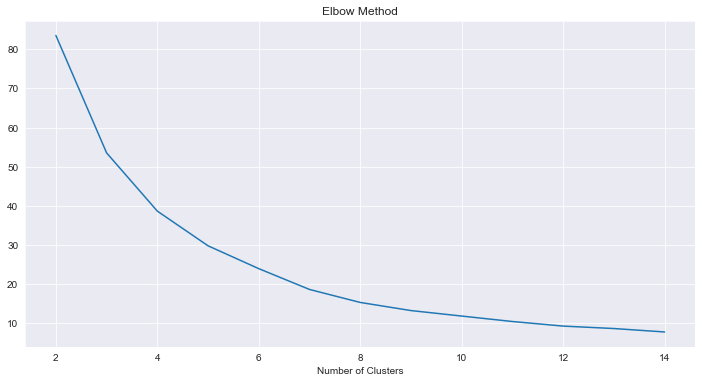

In [21]:
# empty list to inertia
inertia = []

for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    
# Plot elbow curve
plt.figure(figsize=(12,6))
plt.plot(range(2,15), inertia)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.show()

In [22]:
# Final model
kmeans = KMeans(n_clusters=4, random_state=42).fit(scaled_data)
labels = kmeans.labels_

# Add labels to df
df_final2["cluster_labels"] = labels

- Now that we have our clusters, let's visualize them and try to get some insights.

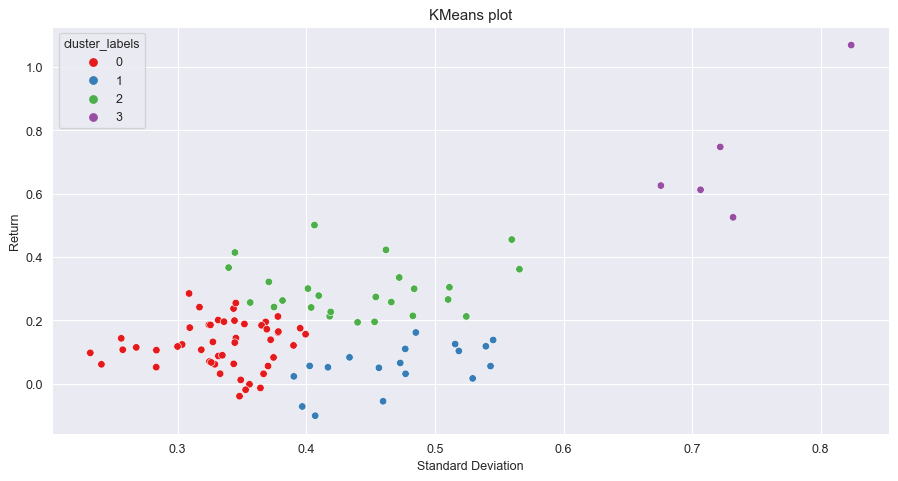

In [41]:
# plot and the different clusters
plt.figure(figsize=(12,6), dpi=90)
sns.scatterplot(x="annual_std", y="annual_ret",
                palette="Set1", data=df_final2, 
                hue="cluster_labels")

plt.title("KMeans plot")
plt.xlabel("Standard Deviation")
plt.ylabel("Return")
plt.show()

- The final scatterplot shows the results of the K-Means clustering analysis. With our analysis, we have been able to identify four distinct clusters, each signifying a unique group of stocks with varying risk and return profiles for the analyzed period. The purple cluster could potentially be interpreted as a cluster comprised of equities with the potential of generating very high returns accompanied with an equally high volatility/risk. 